In [1]:
from pytorch_tools import CreateDataset, train_model_cls, train_model_reg, plot_metrics

/Users/aleksejkitajskij/Desktop/DS-Lifehacks/pytorch/pytorch_tools.py:19: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## binary classification

In [2]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/Module_1_Lecture_2_Class_Spaceship_Titanic.csv')
df = df.set_index('PassengerId')

TARGET = 'Transported'
FEATURES = [col for col in df.columns if col != TARGET]

imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
imputer = SimpleImputer(strategy='median')
imputer.fit(df[imputer_cols])
df[imputer_cols] = imputer.transform(df[imputer_cols])

df["HomePlanet"].fillna('Gallifrey', inplace=True)
df["Destination"].fillna('Skaro', inplace=True)

df['CryoSleep_is_missing'] = df['CryoSleep'].isna().astype(int)
df['VIP_is_missing'] = df['VIP'].isna().astype(int)

df["CryoSleep"].fillna(False, inplace=True)
df["VIP"].fillna(False, inplace=True)

df["CryoSleep"] = df["CryoSleep"].astype(int)
df["VIP"] = df["VIP"].astype(int)

dummies = pd.get_dummies(df.loc[:, ['HomePlanet', 'Destination']], dtype=int)

df = pd.concat([df, dummies], axis=1)
df.drop(columns=['HomePlanet', 'Destination'], inplace=True)

df[TARGET] = df[TARGET].astype(int)

df.drop(["Name" ,"Cabin"] , axis=1 ,inplace = True)

In [4]:
X = df.drop(TARGET , axis =1 ).values
y = df[TARGET].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.33, stratify = y)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [5]:
train_dataset = CreateDataset(X_train, y_train, scaler='StandardScaler')
test_dataset = CreateDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,
                              batch_size=len(X_train),
                              num_workers=0
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=len(X_test),
                              num_workers=0
                             )

In [6]:
class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

In [7]:
input_dim = X_train.shape[1]
model = Net(input_dim)
parameters = list(model.parameters())

criterion = nn.BCELoss()
optimizer = optim.SGD(parameters, lr=0.01)

In [8]:
parameters

[Parameter containing:
 tensor([[ 0.1118, -0.0673, -0.2300,  0.2257,  0.1164, -0.1635,  0.2298,  0.1018,
           0.1456, -0.0209,  0.1972,  0.0843,  0.0630, -0.0648,  0.1648, -0.1329,
           0.1803, -0.1054]], requires_grad=True),
 Parameter containing:
 tensor([-0.0735], requires_grad=True)]

In [9]:
metrics, model = train_model_cls(
    num_classes=2,
    num_epoch=100,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    info_every_iter=5
)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/100] Train Loss: 0.7540 Acc: 0.5076 Rec: 0.3710 Prec: 0.5154
Epoch [10/100] Train Loss: 0.7474 Acc: 0.5134 Rec: 0.3778 Prec: 0.5234
Epoch [15/100] Train Loss: 0.7409 Acc: 0.5206 Rec: 0.3870 Prec: 0.5331
Epoch [20/100] Train Loss: 0.7346 Acc: 0.5266 Rec: 0.3928 Prec: 0.5414
Epoch [25/100] Train Loss: 0.7285 Acc: 0.5290 Rec: 0.3955 Prec: 0.5446
Epoch [30/100] Train Loss: 0.7225 Acc: 0.5398 Rec: 0.4136 Prec: 0.5582
Epoch [35/100] Train Loss: 0.7167 Acc: 0.5510 Rec: 0.4306 Prec: 0.5720
Epoch [40/100] Train Loss: 0.7111 Acc: 0.5664 Rec: 0.4613 Prec: 0.5888
Epoch [45/100] Train Loss: 0.7056 Acc: 0.5766 Rec: 0.4777 Prec: 0.6000
Epoch [50/100] Train Loss: 0.7003 Acc: 0.5826 Rec: 0.4859 Prec: 0.6069
Epoch [55/100] Train Loss: 0.6951 Acc: 0.5901 Rec: 0.4995 Prec: 0.6145
Epoch [60/100] Train Loss: 0.6901 Acc: 0.5944 Rec: 0.5094 Prec: 0.6181
Epoch [65/100] Train Loss: 0.6852 Acc: 0.6003 Rec: 0.5193 Prec: 0.6239
Epoch [70/100] Train Loss: 0.6804 Acc: 0.6065 Rec: 0.5302 Prec: 0.6298
Epoch [

In [10]:
with torch.no_grad():
    y_pred = model(X_test).squeeze().numpy().round()

accuracy_score(y_test, y_pred)

0.3001045660508888

In [11]:
parameters

[Parameter containing:
 tensor([[ 0.3085, -0.0941, -0.2072,  0.0993,  0.1166, -0.1220,  0.0921, -0.0090,
           0.1202, -0.0233,  0.1122,  0.1341,  0.0553, -0.0099,  0.1512, -0.1091,
           0.1400, -0.0954]], requires_grad=True),
 Parameter containing:
 tensor([-0.0548], requires_grad=True)]

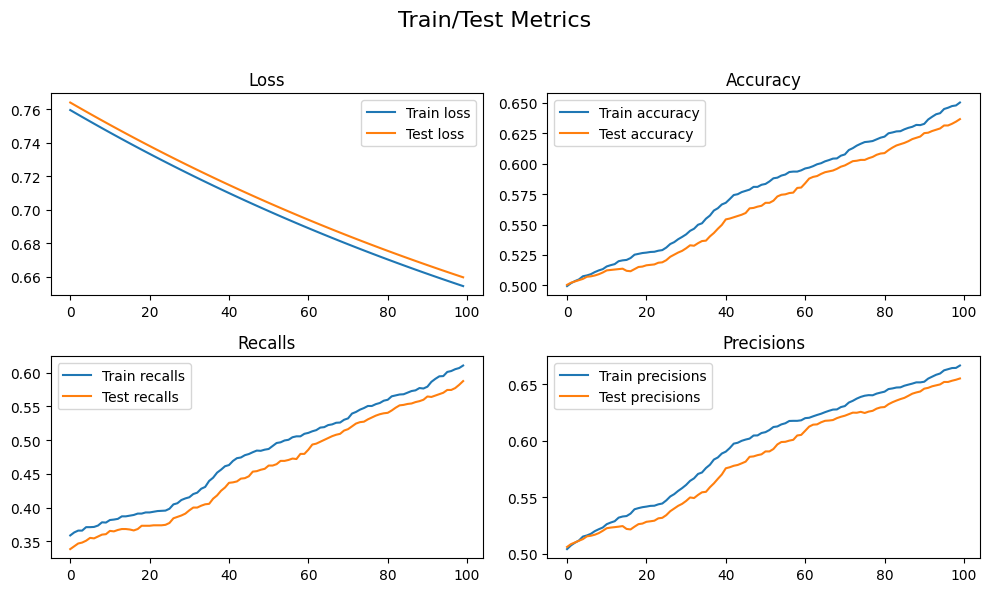

In [12]:
plot_metrics(metrics)

## multyclass classification

In [13]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [14]:
df = pd.read_csv('data/Module_2_Lecture_2_Class_penguins.csv')
df = df.dropna().reset_index(drop=True)
features = ['species', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
df = df.loc[:, features]
df.loc[df['species']=='Adelie', 'species']=0
df.loc[df['species']=='Gentoo', 'species']=1
df.loc[df['species']=='Chinstrap', 'species']=2
df = df.apply(pd.to_numeric)

In [15]:
X = df.drop('species', axis =1).values
y = df['species'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size =0.33, stratify=y)

X_train = torch.Tensor(X_train).float()
y_train = torch.Tensor(y_train).long()
X_test = torch.Tensor(X_test).float()
y_test = torch.Tensor(y_test).long()

In [16]:
train_dataset = CreateDataset(X_train, y_train, scaler='StandardScaler')
test_dataset = CreateDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,
                              batch_size=20,
                              num_workers=0
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=20,
                              num_workers=0
                             )

In [17]:
train_dataset.scaler

StandardScaler()

In [18]:
num_classes = len(np.unique(y_train))
num_classes

3

In [19]:
class Net(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim=20, out_dim=3):
        super().__init__()
        
        self.features = torch.nn.Sequential(
            
            nn.Linear(in_dim, hidden_dim),
            torch.nn.ReLU(),
            
            nn.Linear(hidden_dim, out_dim),
            nn.Softmax()
        )    
        
    def forward(self, x):
        output = self.features(x)
        return output

In [20]:
model = Net(X_train.shape[1], 20, num_classes)
parameters = list(model.parameters())

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(parameters, lr=0.01)

In [21]:
metrics, model = train_model_cls(
    num_classes=num_classes,
    num_epoch=100,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    model=model,
    criterion=criterion,
    optimizer=optimizer
)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100] Train Loss: 1.1034 Acc: 0.2292 Rec: 0.2292 Prec: 0.0935
Epoch [2/100] Train Loss: 1.0948 Acc: 0.2625 Rec: 0.2625 Prec: 0.1029
Epoch [3/100] Train Loss: 1.0861 Acc: 0.2875 Rec: 0.2875 Prec: 0.1100
Epoch [4/100] Train Loss: 1.0772 Acc: 0.3238 Rec: 0.3238 Prec: 0.2826
Epoch [5/100] Train Loss: 1.0683 Acc: 0.3688 Rec: 0.3688 Prec: 0.3677
Epoch [6/100] Train Loss: 1.0592 Acc: 0.4138 Rec: 0.4138 Prec: 0.4053
Epoch [7/100] Train Loss: 1.0500 Acc: 0.4792 Rec: 0.4792 Prec: 0.4458
Epoch [8/100] Train Loss: 1.0408 Acc: 0.5404 Rec: 0.5404 Prec: 0.4613
Epoch [9/100] Train Loss: 1.0314 Acc: 0.5922 Rec: 0.5922 Prec: 0.4886
Epoch [10/100] Train Loss: 1.0219 Acc: 0.6209 Rec: 0.6209 Prec: 0.5053
Epoch [11/100] Train Loss: 1.0123 Acc: 0.6311 Rec: 0.6311 Prec: 0.5052
Epoch [12/100] Train Loss: 1.0027 Acc: 0.6345 Rec: 0.6345 Prec: 0.5054
Epoch [13/100] Train Loss: 0.9931 Acc: 0.6345 Rec: 0.6345 Prec: 0.5051
Epoch [14/100] Train Loss: 0.9834 Acc: 0.6345 Rec: 0.6345 Prec: 0.5048
Epoch [15/100] 

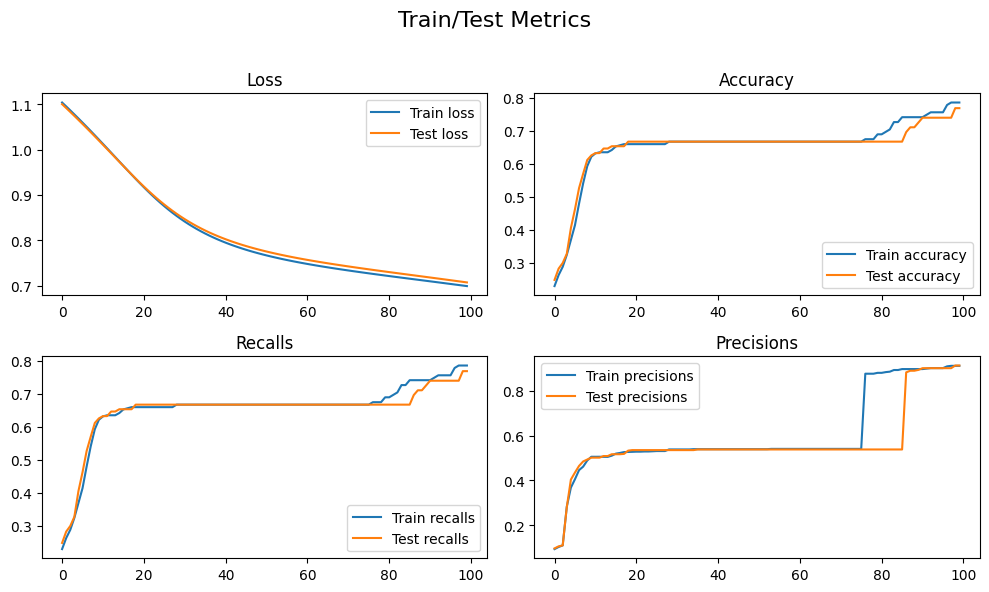

In [22]:
plot_metrics(metrics)

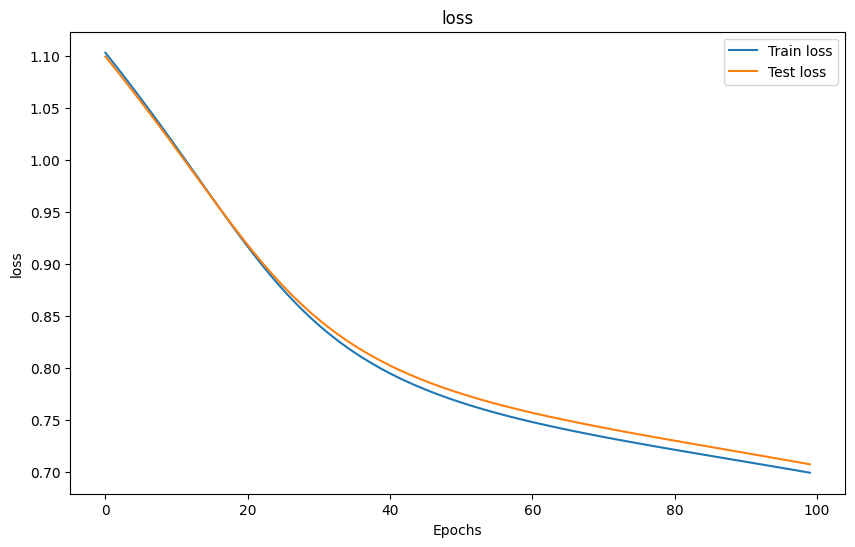

In [23]:
plot_metrics(metrics, 'loss')

## regression

In [24]:
from dataclasses import dataclass

import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [25]:
data_path = 'data/Module_2_Lecture_2_Class_bigmart_data.csv'
data = pd.read_csv(data_path)
data['Outlet_Establishment_Year'] = 2013 - data['Outlet_Establishment_Year']
data['Item_Visibility'] = (data['Item_Visibility']
                           .mask(data['Item_Visibility'].eq(0), np.nan))

data['Item_Visibility_Avg'] = (data
                               .groupby(['Item_Type',
                                         'Outlet_Type'])['Item_Visibility']
                               .transform('mean'))

data['Item_Visibility'] = (
    data['Item_Visibility'].fillna(data['Item_Visibility_Avg']))

data['Item_Visibility_Ratio'] = (
    data['Item_Visibility'] / data['Item_Visibility_Avg'])

data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'reg': 'Regular'})

data['Item_Identifier_Type'] = data['Item_Identifier'].str[:2]
data_num = data.select_dtypes(include=np.number)
data_cat = data.select_dtypes(include='object')

In [26]:
X_train_num, X_test_num, X_train_cat,  X_test_cat, y_train, y_test = (
    train_test_split(
        data_num.drop(['Item_Outlet_Sales',
                       'Item_Visibility_Avg'], axis=1).values,
        data_cat.drop('Item_Identifier', axis=1).values,
        data['Item_Outlet_Sales'].values,
        test_size=0.2,
        random_state=42))

num_imputer = SimpleImputer().set_output(transform='pandas')
X_train_num = num_imputer.fit_transform(X_train_num)
X_test_num = num_imputer.transform(X_test_num)

cat_imputer = SimpleImputer(strategy='most_frequent').set_output(transform='pandas')
X_train_cat = cat_imputer.fit_transform(X_train_cat)
X_test_cat = cat_imputer.transform(X_test_cat)
enc_auto = TargetEncoder(random_state=42).set_output(transform='pandas')
X_train_cat = enc_auto.fit_transform(X_train_cat, y_train)
X_test_cat = enc_auto.transform(X_test_cat)

X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)

In [27]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6818, 12), (1705, 12), (6818,), (1705,))

In [28]:
train_dataset = CreateDataset(X_train, y_train)
test_dataset = CreateDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,
                              batch_size=20,
                              num_workers=0
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=20,
                              num_workers=0
                             )

In [29]:
class LinearModel(torch.nn.Module):
    def __init__(self, in_dim, out_dim=1):
        super().__init__()
        
        self.features = torch.nn.Sequential(
            nn.Linear(in_dim, 256),
            torch.nn.ReLU(),
            
            nn.Linear(256, 128),
            torch.nn.ReLU(),
            
            nn.Linear(128, 64),
            torch.nn.ReLU(),
            
            nn.Linear(64, out_dim),
        )
    
        
    def forward(self, x):
        output = self.features(x)
        return output

In [30]:
model = LinearModel(in_dim=X_train.shape[1], out_dim=1)
  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [31]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print("Використовується пристрій:", device)

Використовується пристрій: mps


In [32]:
metrics, model = train_model_reg(num_epoch=20,
                    train_dataloader = train_dataloader,
                    test_dataloader = test_dataloader,
                    model=model,
                    criterion=criterion,
                    optimizer=optimizer,
                    device=device,
                    show_val_metrics=True,
                    info_every_iter=2
                    )

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/20] Train Loss: 6138480.2222 MSE: 6138483.0000 MAE: 1856.7344 RMSE: 2477.5962
Epoch [2/20] Val Loss: 3829153.8123 MSE: 3829154.2500 MAE: 1387.3705 RMSE: 1956.8225
Epoch [4/20] Train Loss: 1597149.3956 MSE: 1597149.1250 MAE: 947.5047 RMSE: 1263.7837
Epoch [4/20] Val Loss: 1310531.6618 MSE: 1310531.7500 MAE: 881.8612 RMSE: 1144.7846
Epoch [6/20] Train Loss: 1363770.9463 MSE: 1363771.1250 MAE: 873.9343 RMSE: 1167.8061
Epoch [6/20] Val Loss: 1171178.6063 MSE: 1171178.3750 MAE: 816.6322 RMSE: 1082.2099
Epoch [8/20] Train Loss: 1296273.3414 MSE: 1296273.7500 MAE: 836.4719 RMSE: 1138.5402
Epoch [8/20] Val Loss: 1126373.6281 MSE: 1126373.5000 MAE: 784.3011 RMSE: 1061.3074
Epoch [10/20] Train Loss: 1271303.8686 MSE: 1271303.7500 MAE: 818.7536 RMSE: 1127.5211
Epoch [10/20] Val Loss: 1110118.3376 MSE: 1110118.5000 MAE: 768.5852 RMSE: 1053.6216
Epoch [12/20] Train Loss: 1259476.1873 MSE: 1259476.6250 MAE: 809.6700 RMSE: 1122.2641
Epoch [12/20] Val Loss: 1102101.7335 MSE: 1102101.6250 MAE:

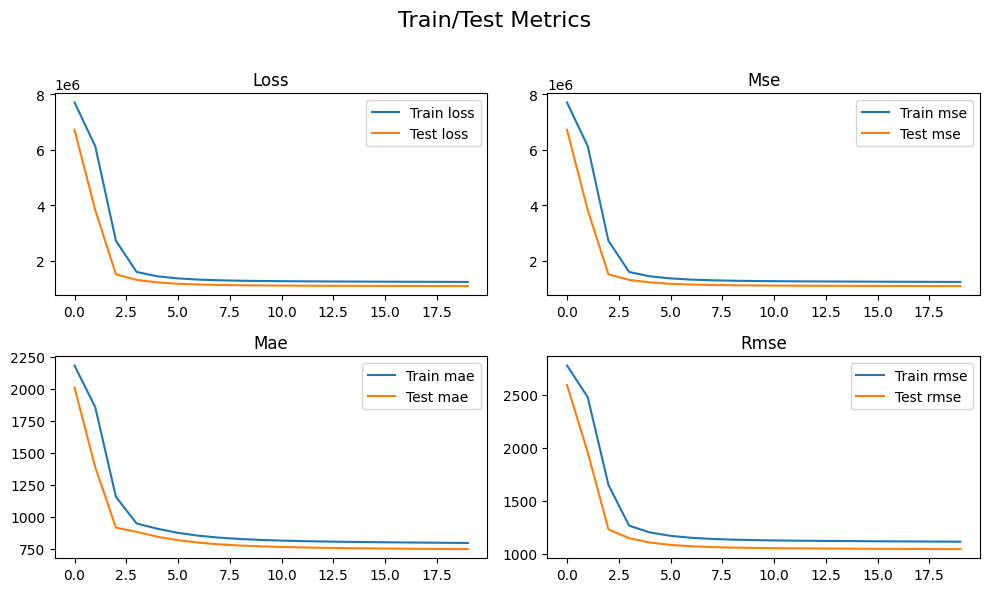

In [33]:
plot_metrics(metrics)